### Decision Tree Model for predicting median_house_value based on location
By Caleb Colbert

#### 1. Prepare Data:

Get the data from the prepocessed_dataset and split it into its training and test sets 

In [16]:
import pandas as pd

# Import dataset
dataset = pd.read_csv('datasets/preprocessed_dataset.csv')


In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = dataset[['longitude', 'latitude', 'ocean_proximity_encoded', 'median_income']]
y = dataset[['median_house_value']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale y
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X


,longitude,latitude,ocean_proximity_encoded,median_income
0,-122.23,37.88,2,8.3252
1,-122.22,37.86,2,8.3014
2,-122.26,37.84,2,2.0804
3,-122.26,37.85,2,2.1250
4,-122.26,37.84,2,1.9911
...,...,...,...,...
18374,-121.09,39.48,4,1.5603
18375,-121.21,39.49,4,2.5568
18376,-121.22,39.43,4,1.7000
18377,-121.32,39.43,4,1.8672


#### 2. Train the model:
Run 20 iterations over 20 different max_depths. After each new model is trained with a different max_depth, test the R^2 value, mean squared error, and mean absolute percentage error

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Initialize the base regressor
regressor = DecisionTreeRegressor(random_state=42)

param_grid = {'max_depth': range(1, 21)}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train_scaled)

# Lists to store scoring values for each depth
mse_values = []
r2_values = []
mape_values = []

# Test each model and score with MSE, R2, and MAPE
for depth in param_grid['max_depth']:
    # Create a new model with this depth
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train_scaled, y_train_scaled)

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)

    # Compute metrics
    mse = mean_squared_error(y_test_scaled, y_pred)
    r2 = r2_score(y_test_scaled, y_pred)
    mape = mean_absolute_percentage_error(y_test_scaled, y_pred)

    # Store the metrics
    mse_values.append(mse)
    r2_values.append(r2)
    mape_values.append(mape)

# Output the best depth from GridSearchCV
print(f"Best max_depth from GridSearchCV: {grid_search.best_params_['max_depth']}")


Best max_depth from GridSearchCV: 10


#### 3. Retrain Model and test with best depth:

In [25]:
# Get Best Depth
best_depth = grid_search.best_params_['max_depth']

# Clear Arrays
DT_MSE = []
DT_R2 = []
DT_MAPES = []

# Retrain the model with the best max_depth on the full training set
for i in range(0, 20):
    # Create new datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 + i)
    
    # Scale X
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale y
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # Retrain Model
    final_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
    final_model.fit(X_train_scaled, y_train_scaled)

    # Predict using the final model
    final_predictions = final_model.predict(X_test_scaled)

    # Evaluate metrics on the test set
    DT_MSE.append(mean_squared_error(y_test_scaled, final_predictions))
    DT_R2.append(r2_score(y_test_scaled, final_predictions))
    DT_MAPES.append(mean_absolute_percentage_error(y_test_scaled, final_predictions))

# Save results to file
# Combine metrics into a single DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'MSE': DT_MSE,
    'MAPE': DT_MAPES,
    'R²': DT_R2
})

# Save results to csv
metrics_df.to_csv('results/DT_Results.csv')

# Display final performance
print("Retrained best model:")
print(f"max_depth: {best_depth}")


Retrained best model:
max_depth: 10


#### 4. Plot Depth:

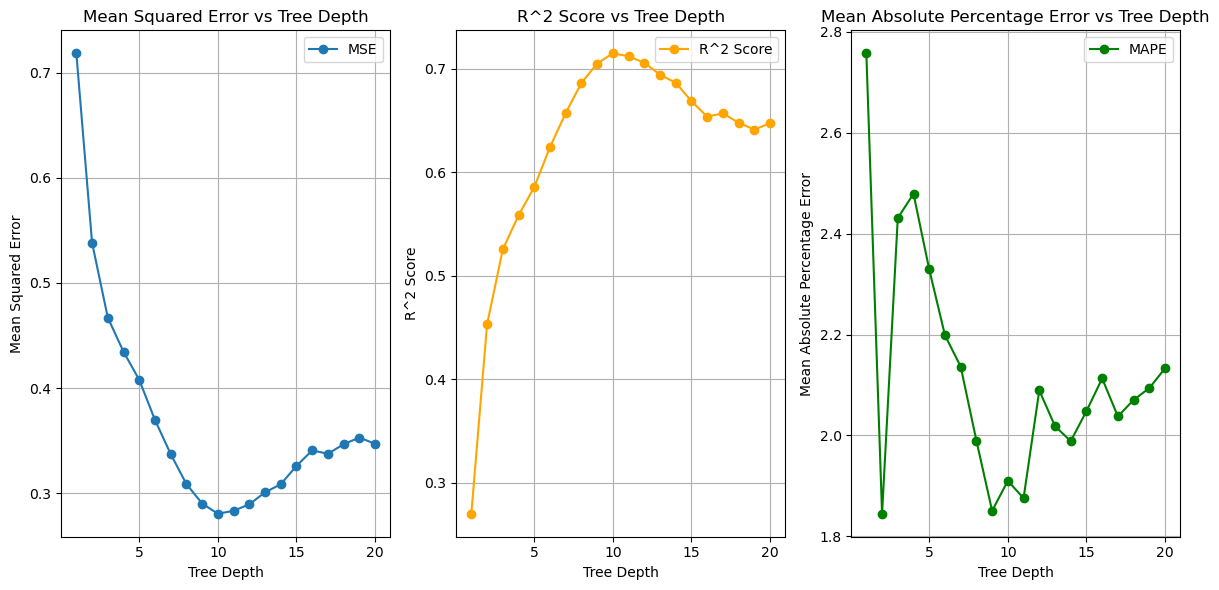

In [24]:
import matplotlib.pyplot as plt

depths = range(1, 21)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 3, 1)
plt.plot(depths, mse_values, marker='o', label='MSE')
plt.title('Mean Squared Error vs Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()

# Plot R^2 Score
plt.subplot(1, 3, 2)
plt.plot(depths, r2_values, marker='o', label='R^2 Score', color='orange')
plt.title('R^2 Score vs Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.legend()

# Plot MAPE
plt.subplot(1, 3, 3)
plt.plot(depths, mape_values, marker='o', label='MAPE', color='green')
plt.title('Mean Absolute Percentage Error vs Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Absolute Percentage Error')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### 5. Plot Error Metrics:

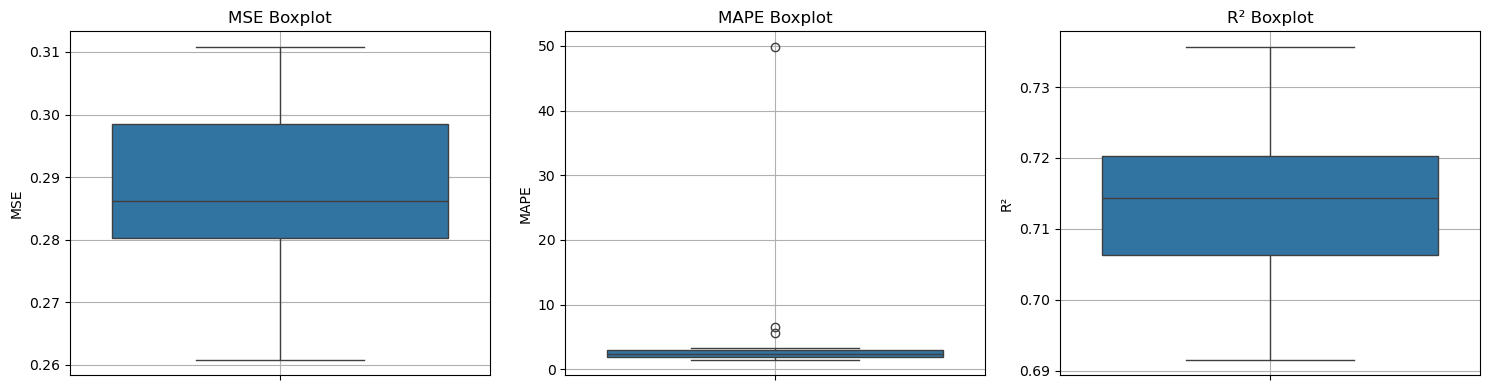

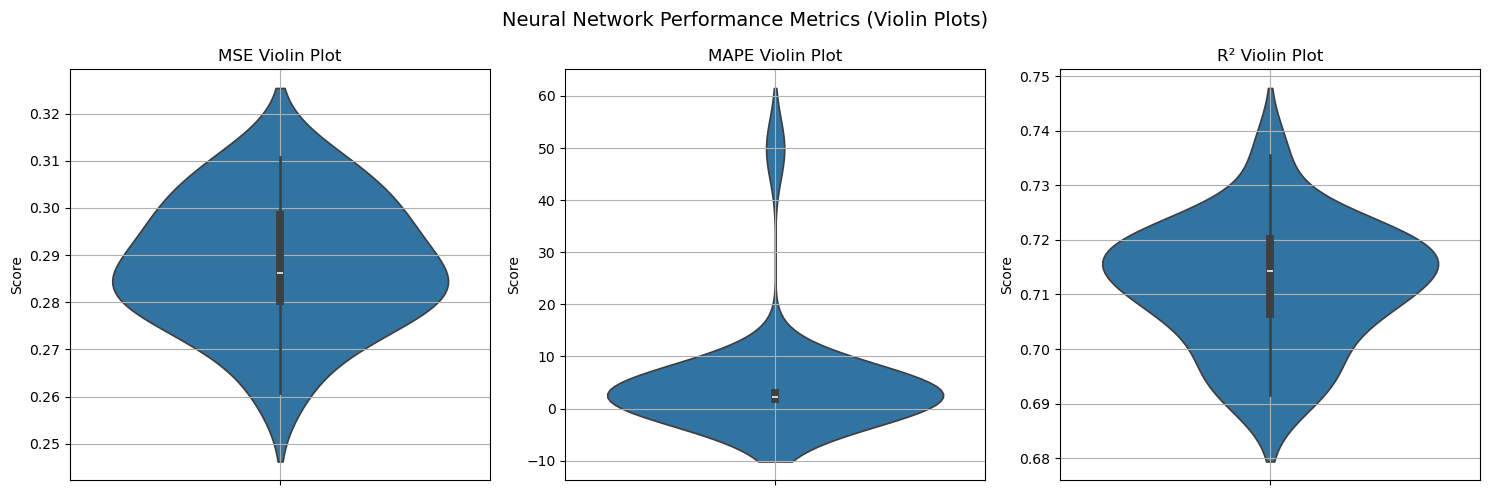

In [23]:
import seaborn as sns

# --- Boxplots ---
plt.figure(figsize=(15, 4))
for i, column in enumerate(metrics_df.columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=metrics_df[column])
    plt.title(f"{column} Boxplot")
    plt.ylabel(column)
    plt.grid(True)
plt.tight_layout()
plt.show()

# --- Violin Plots ---
long_df = metrics_df.melt(var_name='Metric', value_name='Score')
plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics_df.columns, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(y='Score', data=long_df[long_df['Metric'] == metric], inner='box')
    plt.title(f"{metric} Violin Plot")
    plt.grid(True)
plt.suptitle("Neural Network Performance Metrics (Violin Plots)", fontsize=14)
plt.tight_layout()
plt.show()